### To Explore:
1. What was the average length of a traffic stop in 2018?  Example, last available DPS data from 2009.   http://www.azdps.gov/sites/default/files/media/Traffic_Stop_Data_Report_2009.pdf  Specifically table 3.2.
1. What was the average length of the traffic stop in 2018 based on the type of traffic infraction?
1. How does the length of time of the stops involving SIA forms compare to the stops without them?  How much does completion of an SIA form and calling ICE lengthen a stop on average?
1. What, if any conclusions, can you make based on race?

1. Violations of particular interest - gore area violations (ARS 28-644) and driving without a license (ARS 28-3151)
 - month of the year frequency
 - week of the year frequency
 - hour of the day frequency 

1. Segment violations into categories based on mean stop times?
 - violations with a mean time between 1am and 6am
 - violations with a mean time between 6am and 12pm, ect.

1. Segment violations into categories based on mean stop minutes.
 - between x and y - what is the mean time of day for these violations?
 - between y and z - what is the mean time of day for these violations?


Next steps:
1. create column to capture the hour of the day that the stop took place at
1. use crosstab to find the count of stops that happen at each hour of the day
1. create visualization to represent crosstab results
1. read up more on azdps https://www.azdps.gov/about/reports/traffic-stop
1. pull in ARS descriptions https://www.azleg.gov/arsDetail/?title=13 


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime

# import warnings
# warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# exclude ContactNumber column
# since it will not be relevant
# for the analysis I'm doing
traffic_stops = pd.read_excel('data/traffic_stop_data_bulk_2019-0687.xlsx', usecols = [0,2,3,4,5])

# I could read this in more efficiently using
# dtype : Type name or dict of column -> type, default None
# Data type for data or columns. E.g. {‘a’: np.float64, ‘b’: np.int32}
# Use object to preserve data as stored in Excel and not interpret dtype.
# If converters are specified, they will be applied INSTEAD of dtype conversion.
# New in version 0.20.0.

In [3]:
traffic_stops.head()

,DateOfStop,TimeOfStop,EndOfStop,ImmigrationStatusCheck,ViolationCode
0,2018-10-11,13:46,16:51,NaN,NaN
1,2018-09-18,18:08,20:20,NaN,NaN
2,2018-01-26,20:38,02:40,NaN,NaN
3,2018-07-08,18:15,19:15,NaN,NaN
4,2018-02-13,15:15,15:45,NaN,NaN


### Data Preparation

In [4]:
# convert DateofStop into string
# originally it was imported as datetime
traffic_stops.DateOfStop = traffic_stops.DateOfStop.astype(str)

In [5]:
# combine dateofstop with start and end of stop
traffic_stops['date_time_start'] = traffic_stops.DateOfStop + ' ' + traffic_stops.TimeOfStop
traffic_stops['date_time_end'] = traffic_stops.DateOfStop + ' ' + traffic_stops.EndOfStop

In [6]:
# convert to datetime
traffic_stops.date_time_start = pd.to_datetime(traffic_stops.date_time_start)
traffic_stops.date_time_end = pd.to_datetime(traffic_stops.date_time_end)

In [7]:
# https://stackoverflow.com/questions/20480897/pandas-add-one-day-to-column
# convert stops that cross midnight
# so that minutes are computed correctly

# is np.where the most efficient way to do this?
# https://stackoverflow.com/questions/38925082/how-to-compare-two-columns-in-pandas-to-make-a-third-column/38925156

traffic_stops['date_time_end'] = np.where(traffic_stops.EndOfStop.str[0:2] < traffic_stops.TimeOfStop.str[0:2],
                               traffic_stops.date_time_end + datetime.timedelta(days=1),
                               traffic_stops.date_time_end)

In [8]:
# find difference in time
traffic_stops['time_delta'] = traffic_stops.date_time_end - traffic_stops.date_time_start

In [9]:
# why do so many stops have no time duration
# associated with them?
traffic_stops.loc[traffic_stops.time_delta.isna()].shape

(14144, 8)

In [10]:
traffic_stops.time_delta.dropna(inplace=True)

In [11]:
traffic_stops.time_delta.isna().sum()

0

In [12]:
# convert hours, minutes, seconds into total minutes
traffic_stops['time_delta_minutes'] = traffic_stops.time_delta.apply(lambda x: int(x.total_seconds()/60))

In [13]:
traffic_stops.head()

,DateOfStop,TimeOfStop,EndOfStop,ImmigrationStatusCheck,ViolationCode,date_time_start,date_time_end,time_delta,time_delta_minutes
0,2018-10-11,13:46,16:51,NaN,NaN,2018-10-11 13:46:00,2018-10-11 16:51:00,03:05:00,185.0
1,2018-09-18,18:08,20:20,NaN,NaN,2018-09-18 18:08:00,2018-09-18 20:20:00,02:12:00,132.0
2,2018-01-26,20:38,02:40,NaN,NaN,2018-01-26 20:38:00,2018-01-27 02:40:00,06:02:00,362.0
3,2018-07-08,18:15,19:15,NaN,NaN,2018-07-08 18:15:00,2018-07-08 19:15:00,01:00:00,60.0
4,2018-02-13,15:15,15:45,NaN,NaN,2018-02-13 15:15:00,2018-02-13 15:45:00,00:30:00,30.0


In [14]:
# even after the above, there are a large number of 
# violations with an end time earlier than a stop time
# I will drop these for now
# maybe revisit in the future
traffic_stops.loc[traffic_stops.time_delta_minutes < 0].shape

(1054, 9)

In [15]:
# glance at these
traffic_stops.loc[traffic_stops.time_delta_minutes < 0].head()

,DateOfStop,TimeOfStop,EndOfStop,ImmigrationStatusCheck,ViolationCode,date_time_start,date_time_end,time_delta,time_delta_minutes
748,2018-10-24,10:49,10:00,NaN,13-2506A,2018-10-24 10:49:00,2018-10-24 10:00:00,-1 days +23:11:00,-49.0
749,2018-10-24,10:49,10:00,NaN,13-2506A,2018-10-24 10:49:00,2018-10-24 10:00:00,-1 days +23:11:00,-49.0
1251,2018-06-23,19:21,19:11,NaN,13-2508,2018-06-23 19:21:00,2018-06-23 19:11:00,-1 days +23:50:00,-10.0
2972,2018-10-03,07:56,07:44,NaN,13-3415,2018-10-03 07:56:00,2018-10-03 07:44:00,-1 days +23:48:00,-12.0
3257,2018-01-10,10:23,10:21,NaN,13-3102A1B,2018-01-10 10:23:00,2018-01-10 10:21:00,-1 days +23:58:00,-2.0


In [16]:
# remove rows where end time is earlier than stop time
# is there a better way to do this?
traffic_stops = traffic_stops[traffic_stops.time_delta_minutes > 0]

In [17]:
# create column for hour of the day
# and month of the year
traffic_stops['hour'] = traffic_stops.date_time_start.apply(lambda x: x.hour)
traffic_stops['month'] = traffic_stops.date_time_start.apply(lambda x: x.month)
traffic_stops['day_of_week'] = traffic_stops.date_time_start.apply(lambda x: x.weekday())

### Summarize ViolationCodes since there are so many odd balls

In [23]:
# identify violations with fewer than 10 unique violations
less_than_100 = traffic_stops.groupby(traffic_stops.ViolationCode).filter(lambda x: x['ViolationCode'].count() < 100).ViolationCode.unique()

In [24]:
# assign violation types with fewer 
# than 100 unique violations into 'other' category
traffic_stops.loc[traffic_stops.ViolationCode.isin(less_than_100),'ViolationCode'] = 'other'

In [25]:
traffic_stops['ViolationCode'].value_counts().head()

28-701A       137350
28-702.04B     39893
other          34167
28-909A1       25222
28-4135C       20669
Name: ViolationCode, dtype: int64

In [26]:
traffic_stops.ImmigrationStatusCheck.value_counts()

YES    1271
NO      510
Name: ImmigrationStatusCheck, dtype: int64

In [27]:
# how many null violations are there
sum(traffic_stops.ViolationCode.isna())

33632

In [28]:
# how many null violations involved immigration status checks
sum(traffic_stops[traffic_stops.ViolationCode.isna()].loc[:,'ImmigrationStatusCheck'].notnull())

220

### Analysis

In [29]:
traffic_stops.head()

,DateOfStop,TimeOfStop,EndOfStop,ImmigrationStatusCheck,ViolationCode,date_time_start,date_time_end,time_delta,time_delta_minutes,hour,month,day_of_week,ars_number,ars_description
0,2018-10-11,13:46,16:51,NaN,NaN,2018-10-11 13:46:00,2018-10-11 16:51:00,03:05:00,185.0,13.0,10.0,3.0,NaN,NaN
1,2018-09-18,18:08,20:20,NaN,NaN,2018-09-18 18:08:00,2018-09-18 20:20:00,02:12:00,132.0,18.0,9.0,1.0,NaN,NaN
2,2018-01-26,20:38,02:40,NaN,NaN,2018-01-26 20:38:00,2018-01-27 02:40:00,06:02:00,362.0,20.0,1.0,4.0,NaN,NaN
3,2018-07-08,18:15,19:15,NaN,NaN,2018-07-08 18:15:00,2018-07-08 19:15:00,01:00:00,60.0,18.0,7.0,6.0,NaN,NaN
4,2018-02-13,15:15,15:45,NaN,NaN,2018-02-13 15:15:00,2018-02-13 15:45:00,00:30:00,30.0,15.0,2.0,1.0,NaN,NaN


In [36]:
traffic_stops.dtypes

DateOfStop                         object
TimeOfStop                         object
EndOfStop                          object
ImmigrationStatusCheck             object
ViolationCode                      object
date_time_start            datetime64[ns]
date_time_end              datetime64[ns]
time_delta                timedelta64[ns]
time_delta_minutes                float64
hour                              float64
month                             float64
day_of_week                       float64
ars_number                         object
ars_description                    object
dtype: object

In [37]:
# display only whole number statistics
pd.set_option("display.precision", 0)
# find statistics for each ViolationCode

traffic_stops.groupby(traffic_stops.ViolationCode)['time_delta_minutes'] \
    .agg(['mean', 'count', 'var', 'max']) \
    .sort_values(by='mean', ascending=False).head(10)

,mean,count,var,max
ViolationCode,,,,
13-3407A7,206,101,35949,643
28-1381A3,186,172,15301,601
28-1381A1 (DUI) 1ST,174,272,18348,1096
13-3408A2,169,137,33673,1220
13-3408A7,168,131,33053,1220
28-1381A2 (DUI) 1ST,167,129,20254,1096
13-3407A1,166,489,20085,705
28-1383A1,166,166,14151,601
13-3405A2,163,255,32680,1220


In [38]:
len(traffic_stops.ViolationCode.unique())

303

In [40]:
# export to excel
# traffic_stops.groupby(traffic_stops.ViolationCode)['time_delta_minutes'] \
#     .agg(['mean', 'count', 'var', 'max']) \
#     .sort_values(by='mean', ascending=False) \
#     .to_excel("traffic_stops_summary_statistics.xlsx")

## Focus on Specific Violations - Visualizations

In [41]:
# gore area violations (ARS 28-644)
# driving without a license (ARS 28-3151)

### Month of Year

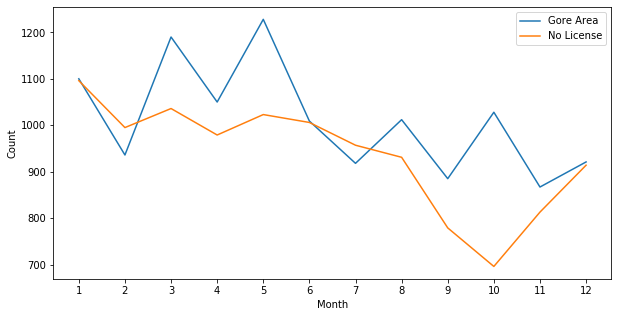

In [42]:
fig, ax = plt.subplots(figsize=(10,5))
# plt.rcParams.update({'font.size': 15})

# plt.rc('axes', titlesize=SMALL_SIZE, labelsize=MEDIUM_SIZE)

x = list(range(1, 13))
gore_area = traffic_stops.loc[traffic_stops.ViolationCode.str.contains(
    '28-644', na=False), 'month'].value_counts().sort_index()
no_license = traffic_stops.loc[traffic_stops.ViolationCode.str.contains(
    '28-3151', na=False), 'month'].value_counts().sort_index()

plt.xlabel("Month")
plt.ylabel("Count")

plt.plot(x, gore_area, label='Gore Area')
plt.plot(x, no_license, label='No License')
plt.legend(fontsize=10)
ax.xaxis.set_major_locator(ticker.MultipleLocator())
# plt.savefig('visualizations/gore_area_no_license_month_of_year.png');

In [48]:
traffic_stops.ViolationCode.value_counts().head()

28-701A       137350
28-702.04B     39893
other          34167
28-909A1       25222
28-4135C       20669
Name: ViolationCode, dtype: int64

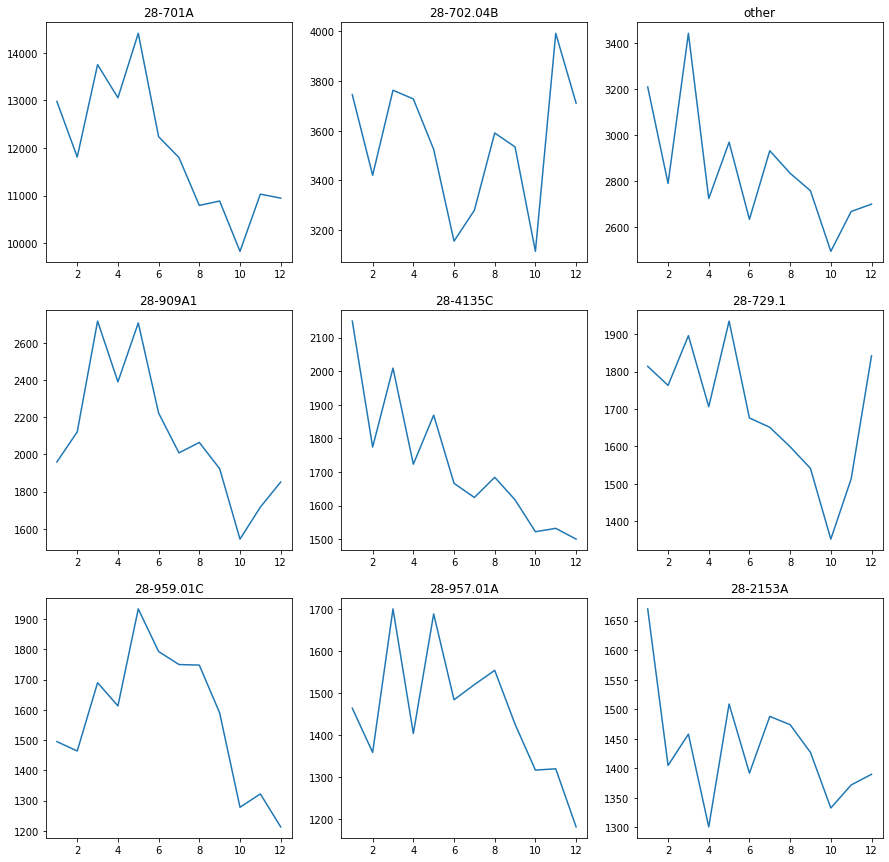

In [44]:
# plot each of the top 9 violations by month of year
fig = plt.figure(figsize=(15, 15))

for i, violation in enumerate(list(traffic_stops.ViolationCode.value_counts().head(9).index)):
    plt.subplot(ceil(len(list(traffic_stops.ViolationCode.value_counts().head(9).index))/3), 3, i+1)
    plt.title(violation)
    
    x = list(range(1, 13))
    y = traffic_stops.loc[traffic_stops.ViolationCode.str.contains(
    violation, na=False), 'month'].value_counts().sort_index()
    
    plt.plot(x, y)
    
#     plt.savefig('visualizations/top_9_violations_month_of_year.png');

### Hour of Day

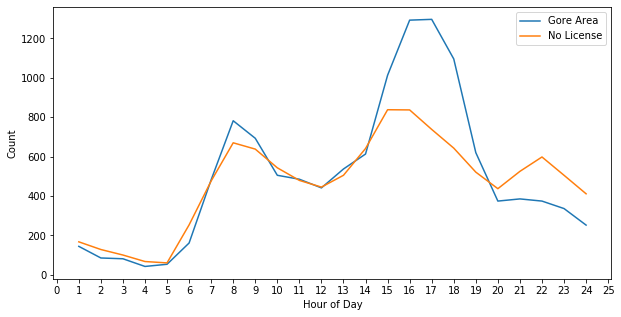

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
# plt.rcParams.update({'font.size': 9})

x = list(range(1, 25))
gore_area = traffic_stops.loc[traffic_stops.ViolationCode.str.contains(
    '28-644', na=False), 'hour'].value_counts().sort_index()
no_license = traffic_stops.loc[traffic_stops.ViolationCode.str.contains(
    '28-3151', na=False), 'hour'].value_counts().sort_index()

plt.xlabel("Hour of Day")
plt.ylabel("Count")

plt.plot(x, gore_area, label='Gore Area')
plt.plot(x, no_license, label='No License')
plt.legend(fontsize=10)
ax.xaxis.set_major_locator(ticker.MultipleLocator())
# plt.savefig('visualizations/gore_area_no_license_hour_of_day.png');

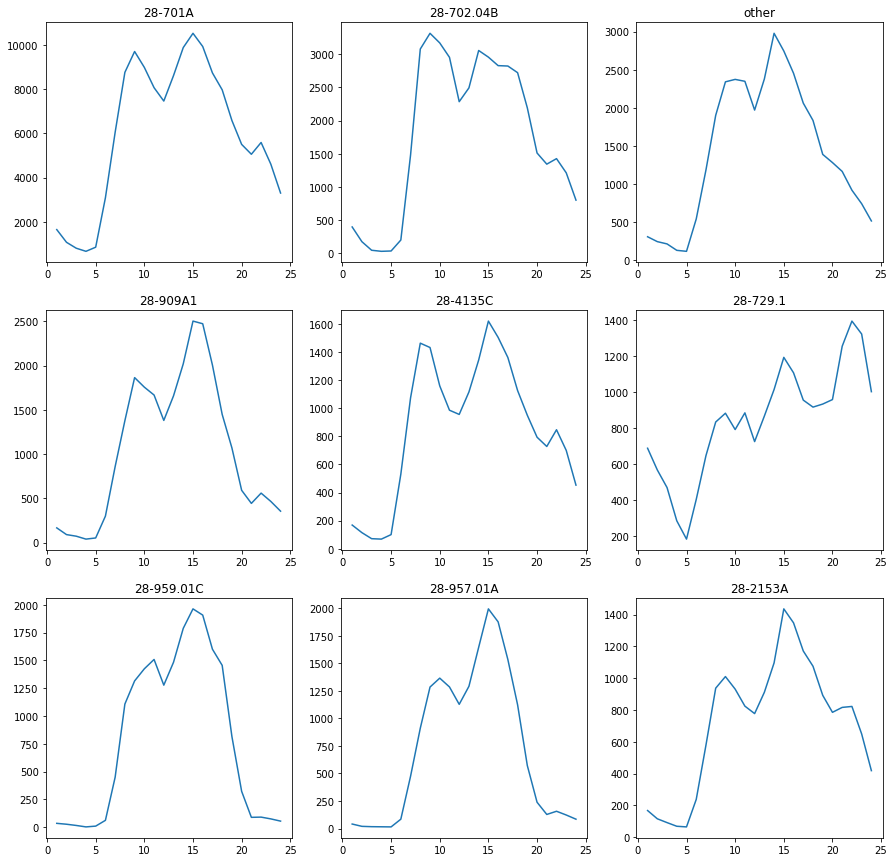

In [46]:
# plot each of the top 9 violations by hour of day
fig = plt.figure(figsize=(15, 15))

for i, violation in enumerate(list(traffic_stops.ViolationCode.value_counts().head(9).index)):
    plt.subplot(ceil(len(list(traffic_stops.ViolationCode.value_counts().head(9).index))/3), 3, i+1)
    plt.title(violation)
    
    x = list(range(1, 25))
    y = traffic_stops.loc[traffic_stops.ViolationCode.str.contains(
    violation, na=False), 'hour'].value_counts().sort_index()
    
    plt.plot(x, y)
    
#     plt.savefig('visualizations/top_9_violations_hour_of_day.png');

### Day of Week

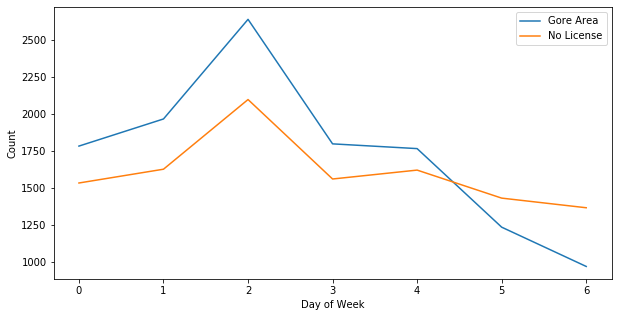

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
# plt.rcParams.update({'font.size': 9})

x = sorted(list(traffic_stops.day_of_week.unique()))[0:7]
gore_area = traffic_stops.loc[traffic_stops.ViolationCode.str.contains(
    '28-644', na=False), 'day_of_week'].value_counts().sort_index()
no_license = traffic_stops.loc[traffic_stops.ViolationCode.str.contains(
    '28-3151', na=False), 'day_of_week'].value_counts().sort_index()

plt.xlabel("Day of Week")
plt.ylabel("Count")

plt.plot(x, gore_area, label='Gore Area')
plt.plot(x, no_license, label='No License')
plt.legend(fontsize=10)
ax.xaxis.set_major_locator(ticker.MultipleLocator())
# plt.savefig('visualizations/gore_area_no_license_day_of_week.png');

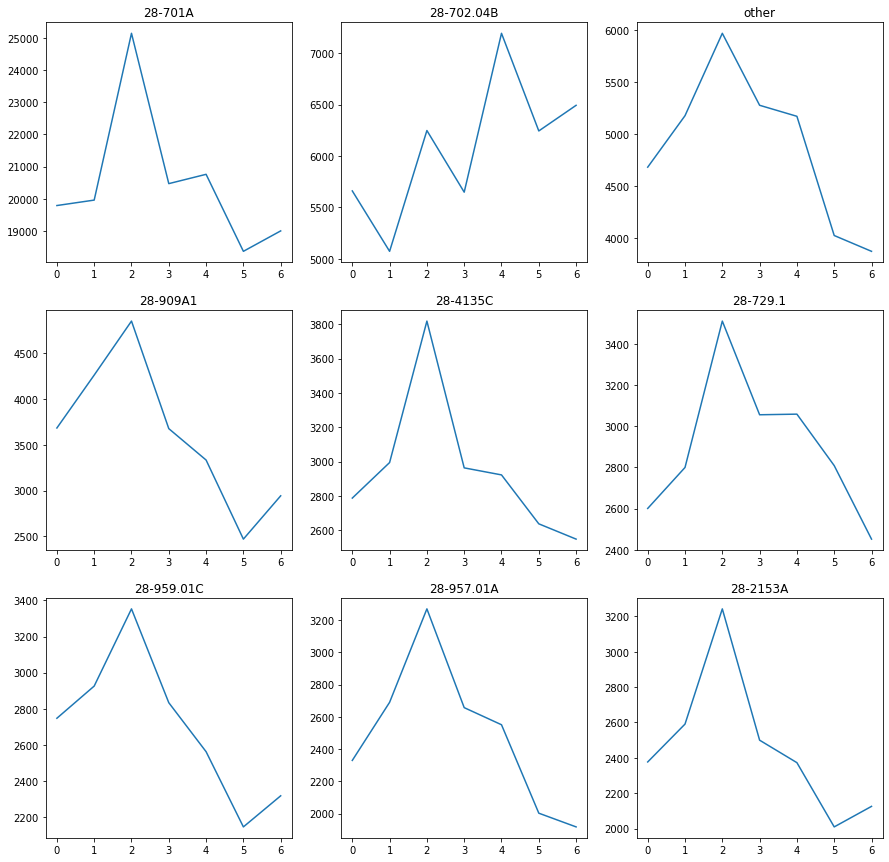

In [54]:
# plot each of the top 9 violations by hour of day
fig = plt.figure(figsize=(15, 15))

for i, violation in enumerate(list(traffic_stops.ViolationCode.value_counts().head(9).index)):
    plt.subplot(ceil(len(list(traffic_stops.ViolationCode.value_counts().head(9).index))/3), 3, i+1)
    plt.title(violation)
    
    x = sorted(list(traffic_stops.day_of_week.unique()))[0:7]
    y = traffic_stops.loc[traffic_stops.ViolationCode.str.contains(
    violation, na=False), 'day_of_week'].value_counts().sort_index()
    
    plt.plot(x, y)
    
#     plt.savefig('visualizations/top_9_violations_day_of_week.png');

## Focus on Specific Violations - Statistics

In [55]:
# violations of interest
violations = [
    '28-644',
    '28-3151' 
]

In [56]:
# 
total_v = pd.DataFrame(columns=['index', 'ViolationCode', 'time_delta_minutes', 'bins'])

for v in violations:
    v_df = traffic_stops.loc[traffic_stops.ViolationCode.str.contains(v, na=False)] \
    .loc[:, ['ViolationCode', 'time_delta_minutes']].sort_values(by='time_delta_minutes', ascending=False).reset_index()
    
    cut_bins = [0,
        ceil(.1 * len(v_df)),
        ceil(.2 * len(v_df)),
        ceil(.3 * len(v_df)),
        ceil(.45 * len(v_df)),
        ceil(.6 * len(v_df)),
             len(v_df)]

    cut_labels = ['%0-10', '%11-20', '%21-30', '%31-45', '%46-60', '%60+']

    v_df['bins'] = pd.cut(v_df.index, bins=cut_bins, labels=cut_labels, include_lowest=True)
    v_df['ViolationCode'] = v
    
    total_v = total_v.append(v_df)

In [57]:
# summarize duration of stop in minutes
pd.options.display.float_format = '{:,.1f}'.format
pd.crosstab(total_v.ViolationCode, total_v.bins, values=total_v.time_delta_minutes, aggfunc='mean')

bins,%0-10,%11-20,%21-30,%31-45,%46-60,%60+
ViolationCode,,,,,,
28-3151,172.2,61.4,44.9,31.2,21.9,13.3
28-644,107.7,20.4,15.9,14.2,11.8,8.5


#### Sub-Violations - Statistics
Many of the violations have more specific sub-categories

In [58]:
# identify subcategories within each violation type
sub_violations = []

for v in violations:
    unique_sub_violations = traffic_stops.loc[traffic_stops.ViolationCode.str.contains(v, na=False), 'ViolationCode'].unique()
    sub_violations.append(list(unique_sub_violations))

# unpack list    
sub_violations = [ x for l in sub_violations for x in l]

In [59]:
total_v = pd.DataFrame(columns=['index', 'ViolationCode', 'time_delta_minutes', 'bins'])

for v in sub_violations:
    v_df = traffic_stops.loc[traffic_stops.ViolationCode.str.contains(v, na=False)] \
    .loc[:, ['ViolationCode', 'time_delta_minutes']].sort_values(by='time_delta_minutes', ascending=False).reset_index()
    
    cut_bins = [0,
        ceil(.1 * len(v_df)),
        ceil(.2 * len(v_df)),
        ceil(.3 * len(v_df)),
        ceil(.45 * len(v_df)),
        ceil(.6 * len(v_df)),
             len(v_df)]

    cut_labels = ['%0-10', '%11-20', '%21-30', '%31-45', '%46-60', '%60+']

    v_df['bins'] = pd.cut(v_df.index, bins=cut_bins, labels=cut_labels, include_lowest=True)
    v_df['ViolationCode'] = v
    
    total_v = total_v.append(v_df)

In [60]:
# summarize duration of stop in minutes
pd.options.display.float_format = '{:,.1f}'.format
pd.crosstab(total_v.ViolationCode, total_v.bins, values=total_v.time_delta_minutes, aggfunc='mean')

bins,%0-10,%11-20,%21-30,%31-45,%46-60,%60+
ViolationCode,,,,,,
28-3151,172.2,61.4,44.9,31.2,21.9,13.3
28-3151A,171.6,61.3,44.9,31.1,21.9,13.3
28-644,107.7,20.4,15.9,14.2,11.8,8.5
28-644A,106.7,20.3,15.8,14.2,11.8,8.5
28-644A1,127.9,27.5,19.3,15.6,13.2,9.2
28-644A2,100.1,20.9,16.3,14.2,11.9,8.4


#### All Other Violations - Statistics

In [118]:
other_stops = traffic_stops.loc[~traffic_stops.ViolationCode.isin(sub_violations),
                  ['ViolationCode', 'time_delta_minutes']]

In [119]:
other_stops.head()

,ViolationCode,time_delta_minutes
0,NaN,185.00
1,NaN,132.00
2,NaN,362.00
3,NaN,60.00
4,NaN,30.00


In [120]:
# perform the above, but for all other violations in aggregate

cut_bins = [0, 10, 20, 30, 45, 60, max(other_stops.time_delta_minutes)]

cut_labels = ['%0-10', '%11-20', '%21-30', '%31-45', '%46-60', '%60+']

other_stops['bins'] = pd.cut(other_stops.time_delta_minutes, bins=cut_bins, labels=cut_labels, include_lowest=True)
other_stops['ViolationCode'] = 'Other'

In [121]:
other_stops.head()

,ViolationCode,time_delta_minutes,bins
0,Other,185.00,%60+
1,Other,132.00,%60+
2,Other,362.00,%60+
3,Other,60.00,%46-60
4,Other,30.00,%21-30


In [123]:
total_v.head()

,ViolationCode,time_delta_minutes,bins
180748,28-644A,12.00,%11-20
180749,28-644A,9.00,%0-10
180750,28-644A,14.00,%11-20
180751,28-644A,20.00,%11-20
180752,28-644A,10.00,%0-10


In [124]:
# combine violations of interest
# with all other violations
all_stops = pd.concat([total_v, other_stops])

In [125]:
# summarize duration of stop in minutes
pd.options.display.float_format = '{:,.2f}'.format
violations_with_distributions = pd.crosstab(all_stops.ViolationCode, all_stops.bins, normalize='index') * 100

In [126]:
violations_with_distributions

bins,%0-10,%11-20,%21-30,%31-45,%46-60,%60+
ViolationCode,,,,,,
28-3151,9.32,35.49,17.82,13.20,9.27,14.90
28-3151A,9.34,35.51,17.80,13.21,9.28,14.85
28-644,37.81,48.49,6.60,2.45,1.19,3.45
28-644A,37.97,48.58,6.49,2.42,1.16,3.37
28-644A1,28.82,49.98,8.86,4.84,2.34,5.17
28-644A2,36.81,48.63,7.53,2.37,1.26,3.40
Other,30.32,40.76,8.62,6.04,4.31,9.94


In [127]:
violations_with_distributions.reset_index()

bins,ViolationCode,%0-10,%11-20,%21-30,%31-45,%46-60,%60+
0,28-3151,9.32,35.49,17.82,13.20,9.27,14.90
1,28-3151A,9.34,35.51,17.80,13.21,9.28,14.85
2,28-644,37.81,48.49,6.60,2.45,1.19,3.45
3,28-644A,37.97,48.58,6.49,2.42,1.16,3.37
4,28-644A1,28.82,49.98,8.86,4.84,2.34,5.17
5,28-644A2,36.81,48.63,7.53,2.37,1.26,3.40
6,Other,30.32,40.76,8.62,6.04,4.31,9.94


In [137]:
# export to excel
violations_with_distributions.reset_index() \
    .to_excel("data/traffic_stops_summary_statistics.xlsx", 
              index=False)

In [128]:
# format to be able to visualize
pd.melt(violations_with_distributions.reset_index(), id_vars='ViolationCode').head()

,ViolationCode,bins,value
0,28-3151,%0-10,9.32
1,28-3151A,%0-10,9.34
2,28-644,%0-10,37.81
3,28-644A,%0-10,37.97
4,28-644A1,%0-10,28.82


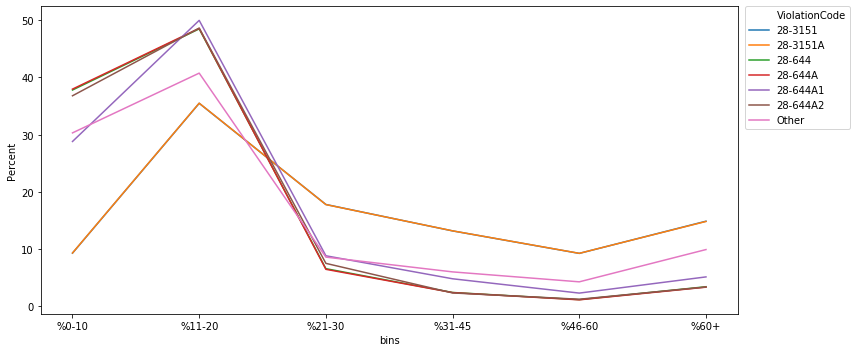

In [133]:
fig, ax = plt.subplots(figsize=(12,5))

sns.lineplot(x=pd.melt(violations_with_distributions.reset_index(), id_vars='ViolationCode').iloc[:,1],
            y=pd.melt(violations_with_distributions.reset_index(), id_vars='ViolationCode').iloc[:,2],
            hue=pd.melt(violations_with_distributions.reset_index(), id_vars='ViolationCode').iloc[:,0])

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.ylabel('Percent')
plt.savefig('visualizations/violations_with_bins.png')
plt.tight_layout();

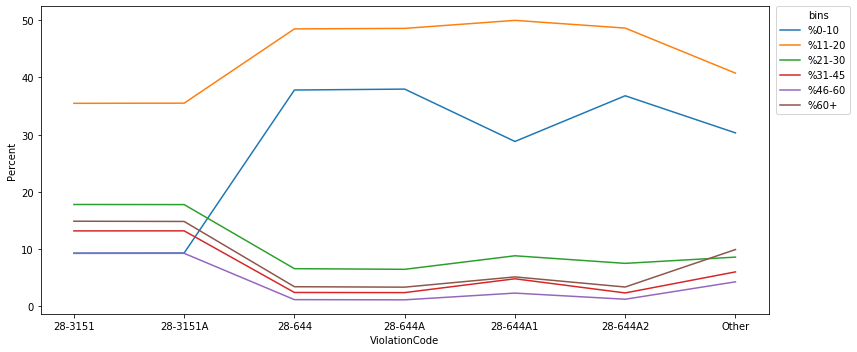

In [134]:
fig, ax = plt.subplots(figsize=(12,5))

sns.lineplot(x=pd.melt(violations_with_distributions.reset_index(), id_vars='ViolationCode').iloc[:,0],
            y=pd.melt(violations_with_distributions.reset_index(), id_vars='ViolationCode').iloc[:,2],
            hue=pd.melt(violations_with_distributions.reset_index(), id_vars='ViolationCode').iloc[:,1])

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.ylabel('Percent')
plt.savefig('visualizations/violations_with_bins2.png')
plt.tight_layout();

## Spare Parts

#### ARS Violation Descriptions

In [ ]:
# I scraped these off that Arizona Legislature website
ars_numbers_descriptions = pd.read_csv('data/ars_numbers_descriptions.csv')

In [ ]:
ars_numbers_descriptions.head()

In [ ]:
# merge traffic stop names into dataframe
# based on ARS number
traffic_stops = traffic_stops.merge(ars_numbers_descriptions, how='outer', left_on='ViolationCode', right_on='ars_number')

In [ ]:
traffic_stops.shape

In [ ]:
# unfortunately, not many were populated
# I think this is because there are so 
# many combinations of violations strung together
traffic_stops.ars_number.isnull().sum()